![title](/home/francescocremonesiext/new-areas/imaging-directions.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import nibabel as nib
from skimage.morphology import binary_dilation, binary_erosion, label
import os
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List, Dict
from functools import reduce
from tqdm import tqdm
import logging
import pickle

In [3]:
from library import define_area_by_specs_with_heuristics, totalseg_tasks
from lymph_node_levels_specs import level_specs

In [3]:

logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
rootLogger = logging.getLogger('root') 

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
consoleHandler.setLevel(logging.DEBUG)
rootLogger.addHandler(consoleHandler)

## Generic functions

This section defines the functions needed for rule-based segmentation of aires ganglionnaires.

In [8]:
path_to_totalseg_segmentations = '/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/cal_cancer_patients/seg_and_metrics_run_2024_04_09/output/SEG'
path_to_ct = '/mnt/lvssd/common/AI4PET/data_v1.0.0/data/02_intermediate/CAL/CT'
totalseg_structure_to_task = {struct: task for task in totalseg_tasks for struct in os.listdir(os.path.join(path_to_totalseg_segmentations, task, '0000002_20171205'))}
output_dir = '/tmp'

In [9]:
#path_to_totalseg_segmentations = '/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/autopet_control_patients/seg_and_metrics_run_2024_11_22/output/SEG'
#path_to_ct = '/mnt/nas/autoPET/data/FDG-PET-CT-Lesions_nifti_neg'
#totalseg_structure_to_task = {struct: task for task in totalseg_tasks for struct in os.listdir(os.path.join(path_to_totalseg_segmentations, task, 'PETCT_1bdefef7d5_20060114'))}
#totalseg_structures = list(totalseg_structure_to_task.keys())

## Process one patient

In [133]:
only_bounding_boxes = True

In [134]:
patient_list = os.listdir(path_to_totalseg_segmentations + '/total')

In [135]:
patient = patient_list[0]

In [136]:
level_specs['level_iii_left']

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [11]:
test_level_specs = {}
test_level_specs['level_iii_left'] = level_specs['level_iii_left']
test_level_specs['level_iii_left'].pop('inferior border')
test_level_specs['level_iii_left'].pop('superior border')
#test_level_specs['level_iii_left'].pop('posterior border')
#test_level_specs['level_iii_left'].pop('anterior border')
#test_level_specs['level_iii_left'].pop('right border')

[{'border': ['inferior border'], 'structure': 'hyoid'}]

In [12]:
#test_level_specs['level_iii_left']['left border'][0]['border'] = ['right border']
test_level_specs

{'level_iii_left': {'posterior border': [{'border': ['posterior border'],
    'structure': 'sternocleidomastoid_left'}],
  'anterior border': [{'border': ['anterior border'],
    'structure': 'sternocleidomastoid_left'}],
  'left border': [{'border': ['left border'],
    'structure': 'sternocleidomastoid_left'}],
  'right border': [{'border': ['right border'],
    'structure': 'common_carotid_artery_left'}]}}

In [137]:
test_level_specs = {}
test_level_specs['level_iii_left'] = level_specs['level_iii_left']

In [138]:
def process_one_patient(patient):
    volumes = list()
    result_levels = list()
    # Generate each area one-by-one in a loop
    combined = None
    for level, specs in test_level_specs.items():
        print(f'Computing {level} for {patient}')
        try:
            # 1. Start by creating a "box" that defines the area
            level_mask = define_area_by_specs_with_heuristics(specs, 
                    patient, 
                    path_to_totalseg_segmentations, 
                    totalseg_structure_to_task)
            # 2. Refinement: remove all other totalsegmentator structures
            if not only_bounding_boxes:
                if combined is None:  # Only for the first time: we combine all other totalsegmentator masks 
                    print(f'Combining all totalseg masks for {patient}')
                    combined = np.zeros_like(level_mask, dtype=np.int32)
                    for structure, task in totalseg_structure_to_task.items():
                        if 'subcutaneous_fat' in structure:
                            print(f'Skipping {structure}')
                            continue
                        segdata = nib.load(os.path.join(
                                            path_to_totalseg_segmentations,
                                            task,
                                            patient,
                                            structure
                                        )).get_fdata()
                        combined = np.clip(combined + segdata.astype(np.int32), 0, 1)
                    print(f'Finished combining all masks for {patient}')
                level_mask *= 1 - combined
            # 3. Refinement: remove space outside of the body
            print(f'Removing space outside body for {patient} {level}')
            body = nib.load(os.path.join(
                                path_to_totalseg_segmentations,
                                'body',
                                patient,
                                'body.nii.gz'
                            )).get_fdata()
            level_mask *= body
            # Save results
            result_levels.append(level_mask)
            volumes.append(level_mask.sum())   
        except Exception as e:
            print(f'Could not process {level} for {patient} because of {e}')
        return result_levels, volumes




In [139]:
result_levels, volumes = process_one_patient(patient)
#with open('test_level_iii_left_0000002_20171205.pkl', 'wb') as f:
#    pickle.dump(result_levels, f)

Computing level_iii_left for 0000002_20171205
Removing space outside body for 0000002_20171205 level_iii_left


/tmp/ipykernel_2141492/551021170.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  level_mask *= body


In [57]:
ct_img = nib.load(os.path.join(path_to_ct, f'{patient}.nii.gz')).get_fdata()

In [141]:
niimage = nib.Nifti1Image(result_levels[0], nib.load(os.path.join(path_to_ct, f'{patient}.nii.gz')).affine, nib.load(os.path.join(path_to_ct, f'{patient}.nii.gz')).header)
nib.save(niimage, f'test_level_iii_left_{patient}.nii.gz')

In [ ]:
lab = nib.load(f'/home/francescocremonesiext/new-areas/aires-ganglionnaires/output/cal_cancer_patients/SEG/0000002_20180215/level_iii_left.nii.gz').get_fdata()

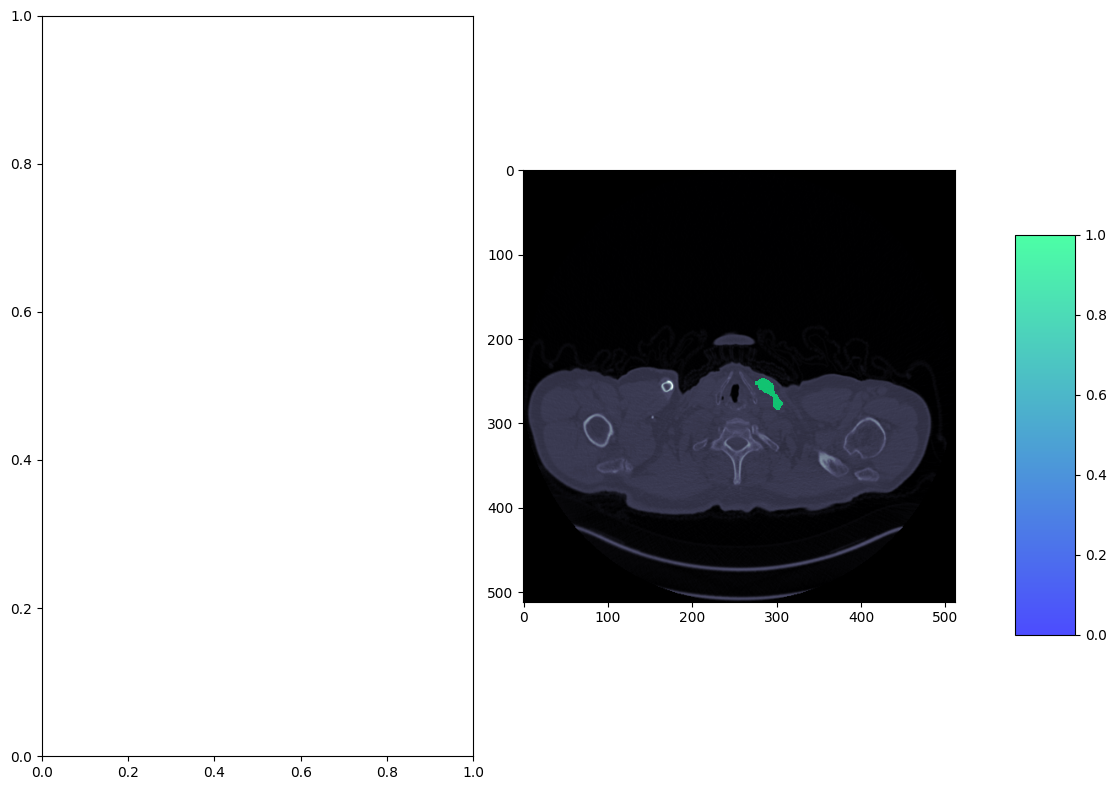

In [140]:
fig, ax = plt.subplots(1,2,figsize=(12,8))


nppred = result_levels[0]

#slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
#slice_ = int(0.5*slice_)
slice_ = np.argmax(nppred.sum(axis=(0,1)))
#slice_ = np.argmax(lab.sum(axis=(0,1))) + 10
#slice_ = np.where(lab > 0)[2].min() + 5
#slice_ = np.where(lab > 0)[2].max() - 55

#ax[0].imshow(ct_img[:,:,slice_].T, cmap='bone')
#ax[0].imshow(np.ma.masked_where(lab[:,:,slice_].T < 0.5, lab[:,:,slice_].T), cmap='winter', alpha=0.5, vmin=0., vmax=1., interpolation='none')

ax[1].imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax[1].imshow(np.ma.masked_where(nppred[:,:,slice_].T < 0.5, nppred[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [19]:
%matplotlib inline

## Tests

In [130]:
from library import define_area_by_plane

In [19]:
import torch

In [15]:
level = 'level_iii_left'
myspecs = level_specs[level]

In [16]:
myspecs

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [17]:
seg_file_path = os.path.join(
                        path_to_totalseg_segmentations,
                        totalseg_structure_to_task['sternocleidomastoid_left.nii.gz'],
                        patient,
                        'sternocleidomastoid_left.nii.gz'
                    )
seg_file_path

'/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/cal_cancer_patients/seg_and_metrics_run_2024_04_09/output/SEG/headneck_muscles/0000002_20171205/sternocleidomastoid_left.nii.gz'

In [60]:
organ_segmentation = torch.tensor(nib.load(seg_file_path).get_fdata()).to(torch.uint8)

In [21]:
type(organ_segmentation)

torch.Tensor

In [22]:
%%timeit 
np.where(organ_segmentation > 0)

KeyboardInterrupt: 

In [18]:
%%timeit
np.where(torch.tensor(organ_segmentation) > 0)

4.82 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:

specs_to_args = {
    'inferior border': {'axis': 2, 'get_largest_index': False,  'one_after': True},
    'superior border': {'axis': 2, 'get_largest_index': True,  'one_after': False},
    'anterior border': {'axis': 1, 'get_largest_index': False,  'one_after': True},
    'posterior border': {'axis': 1, 'get_largest_index': True,  'one_after': False},
    'left border': {'axis': 0, 'get_largest_index': True,  'one_after': False},
    'right border': {'axis': 0, 'get_largest_index': False,  'one_after': True},
}

In [24]:
border = 'left border'
one_after = specs_to_args[border]['one_after']
axis = specs_to_args[border]['axis']
organ_border_name = myspecs[border][0]['border'][0]
get_largest_index = specs_to_args[organ_border_name]['get_largest_index']

In [108]:
axis, one_after, get_largest_index

(0, False, True)

In [48]:
mask = define_area_by_plane(organ_segmentation=organ_segmentation,
                            axis=axis,
                            get_largest_index=get_largest_index,
                            one_after=one_after,
                            slice_by_slice=False,
                            line_by_line=True)

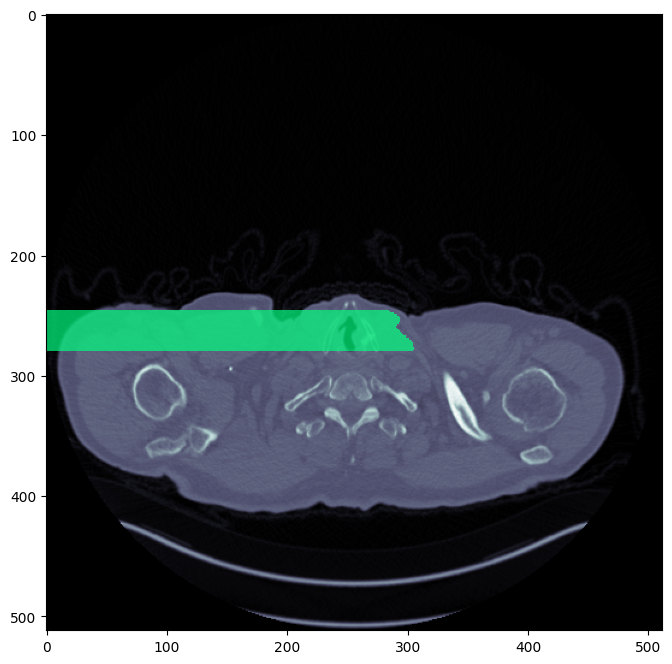

In [50]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(mask[:,:,slice_].T < 0.5, mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [32]:
from library import get_extremal_idx_line_by_line

In [33]:
print(f'{axis} {get_largest_index}')

0 True


In [70]:
area_mask = torch.zeros_like(organ_segmentation)
axis_indices = get_extremal_idx_line_by_line(organ_segmentation, axis, get_largest_index)
other_ax = [0,1,2]
_ = other_ax.pop(axis)
ax1 = other_ax[-1]
ax2 = other_ax[0]

In [71]:
for i in range(len(axis_indices[0])):
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = axis_indices[ax1][i]
    selecting_slice[ax2] = axis_indices[ax2][i]
    selecting_slice[axis] = slice(axis_indices[axis][i], None) if one_after else slice(None, axis_indices[axis][i])
    area_mask[*selecting_slice] = 1

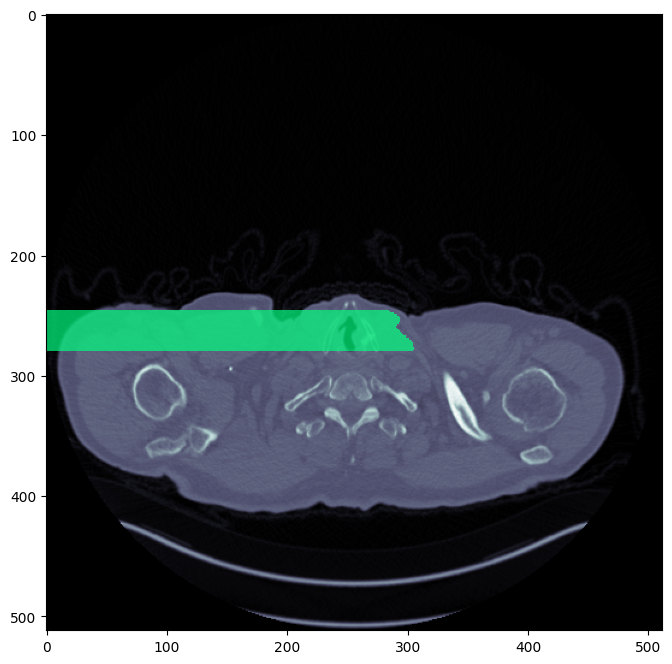

In [72]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(area_mask[:,:,slice_].T < 0.5, area_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [73]:
# extend under min ax1
ax1_idx = np.min(axis_indices[ax1])
w = np.where(axis_indices[ax1] == ax1_idx)[0]
for i in w:
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = slice(0,ax1_idx)
    selecting_slice[ax2] = axis_indices[ax2][i]
    selecting_slice[axis] = slice(axis_indices[axis][i], None) if one_after else slice(None, axis_indices[axis][i])
    area_mask[*selecting_slice] = 1

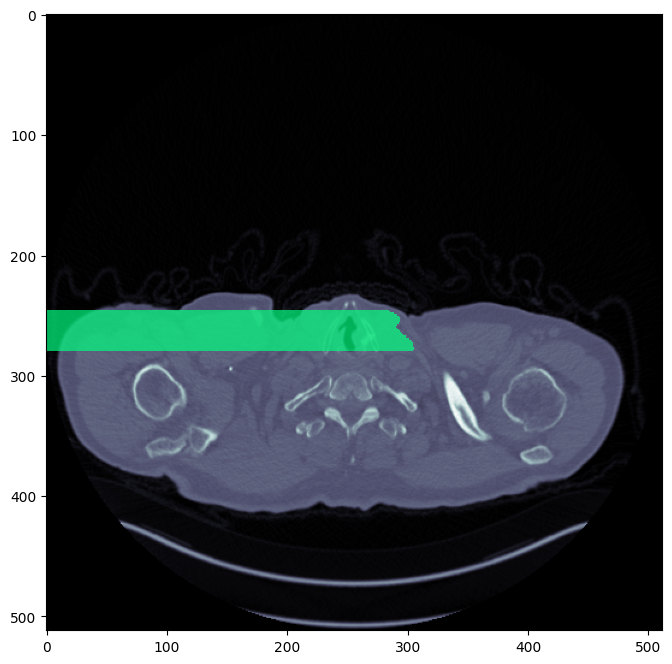

In [74]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(area_mask[:,:,slice_].T < 0.5, area_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [75]:
# extend over max ax1
ax1_idx = np.max(axis_indices[ax1])
w = np.where(axis_indices[ax1] == ax1_idx)[0]
for i in w:
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = slice(ax1_idx,None)
    selecting_slice[ax2] = axis_indices[ax2][i]
    selecting_slice[axis] = slice(axis_indices[axis][i], None) if one_after else slice(None, axis_indices[axis][i])
    area_mask[*selecting_slice] = 1

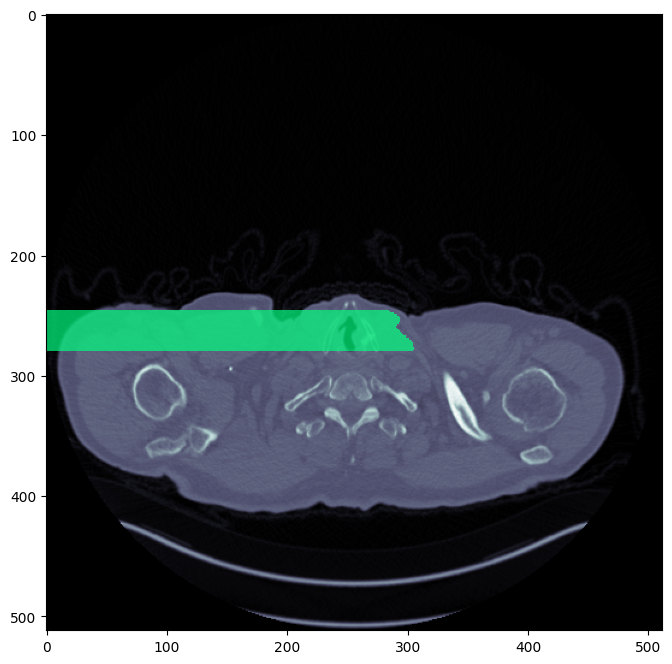

In [76]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(area_mask[:,:,slice_].T < 0.5, area_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [77]:
# extend under min ax2
ax2_idx = np.min(axis_indices[ax2])
w = np.where(axis_indices[ax2] == ax2_idx)[0]
for i in w:
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = axis_indices[ax1][i] 
    selecting_slice[ax2] = slice(0,ax2_idx)
    selecting_slice[axis] = slice(axis_indices[axis][i], None) if one_after else slice(None, axis_indices[axis][i])
    area_mask[*selecting_slice] = 1

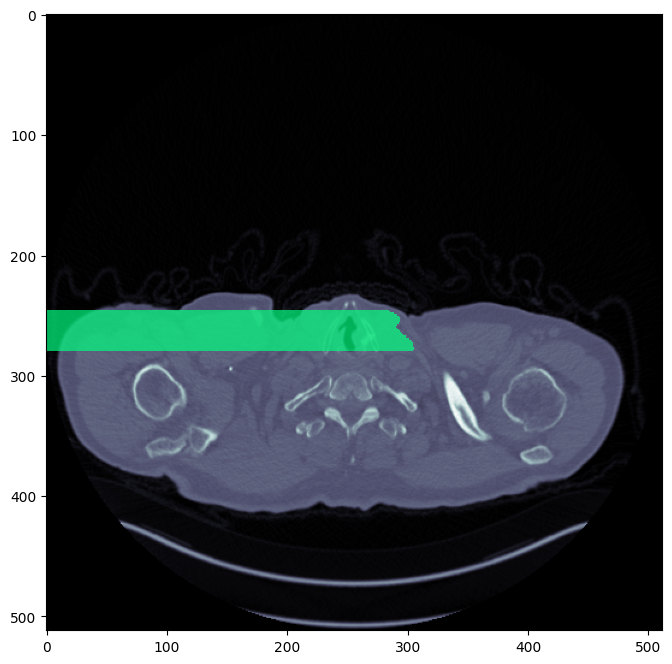

In [78]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(area_mask[:,:,slice_].T < 0.5, area_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [79]:
# extend over max ax2
ax2_idx = np.max(axis_indices[ax2])
w = np.where(axis_indices[ax2] == ax2_idx)[0]
for i in w:
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = axis_indices[ax1][i] 
    selecting_slice[ax2] = slice(ax2_idx,None)
    selecting_slice[axis] = slice(axis_indices[axis][i], None) if one_after else slice(None, axis_indices[axis][i])
    area_mask[*selecting_slice] = 1

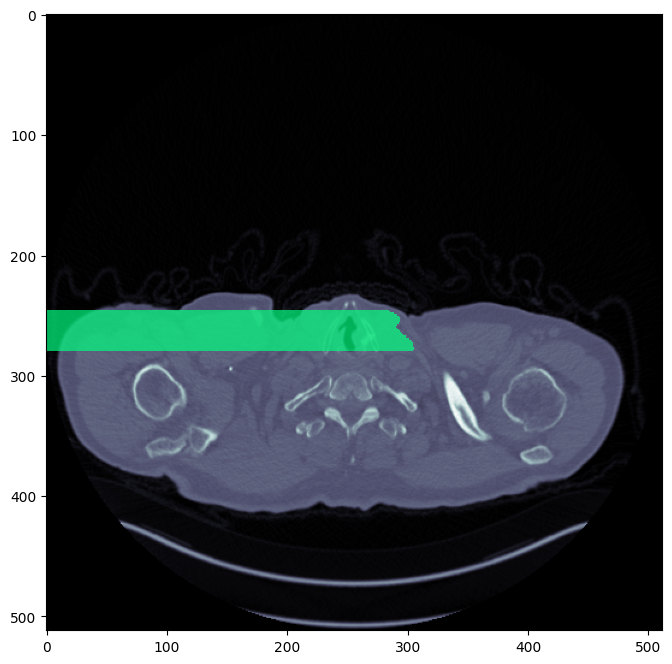

In [80]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(area_mask[:,:,slice_].T < 0.5, area_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [52]:
myspecs

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [53]:
level_mask = define_area_by_specs_with_heuristics(myspecs, 
                    patient, 
                    path_to_totalseg_segmentations, 
                    totalseg_structure_to_task)

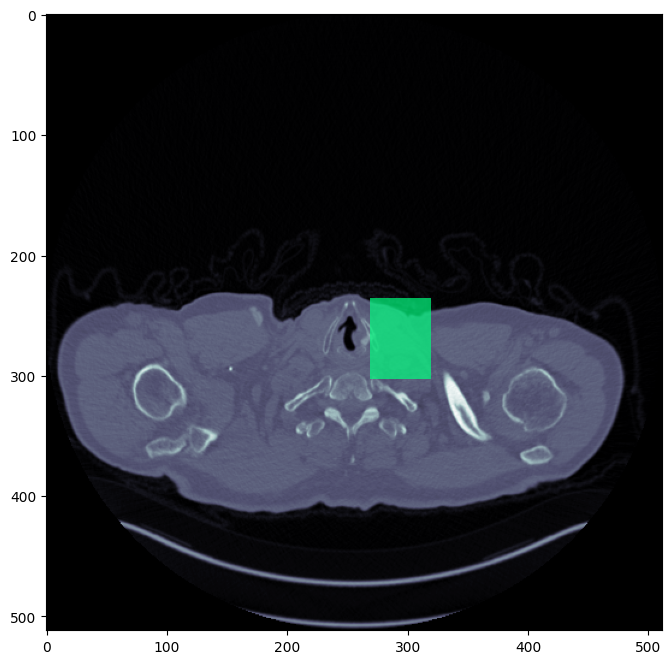

In [54]:
fig, ax = plt.subplots(figsize=(8,8))

slice_ = 719

ax.imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax.imshow(np.ma.masked_where(level_mask[:,:,slice_].T < 0.5, level_mask[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')


plt.show()

In [148]:
import copy

In [149]:
test_specs = {}
test_specs['inferior border'] = copy.deepcopy(myspecs['inferior border'])

In [157]:
do_first_borders =  ['inferior border', 'superior border']
#do_first_borders =  []
slice_by_slice_ = False
line_by_line = (not slice_by_slice_) and True 
def _gen_areas():
    for border in do_first_borders:
        specs = myspecs[border]
        one_after_ = specs_to_args[border]['one_after']
        axis_ = specs_to_args[border]['axis']
        for organ_border_specs in specs:
            seg_filename = organ_border_specs['structure'] + '.nii.gz'
            for organ_border_name in organ_border_specs['border']:
                get_largest_index_ = specs_to_args[organ_border_name]['get_largest_index']
                seg_file_path = os.path.join(
                    path_to_totalseg_segmentations,
                    totalseg_structure_to_task[seg_filename],
                    patient,
                    seg_filename
                )
                organ_segmentation = torch.tensor(nib.load(seg_file_path).get_fdata()).to(torch.uint8)
            yield define_area_by_plane(organ_segmentation, axis_, get_largest_index_, one_after_, False, False)  # slice-by-slice and line-by-line always False for z borders

    # do the other borders
    for border, specs in myspecs.items():
        if border in do_first_borders:
            continue
        #print(f'{patient} {border}')
        one_after_ = specs_to_args[border]['one_after']
        axis_ = specs_to_args[border]['axis']
        for organ_border_specs in specs:
            seg_filename = organ_border_specs['structure'] + '.nii.gz'
            for organ_border_name in organ_border_specs['border']:
                get_largest_index_ = specs_to_args[organ_border_name]['get_largest_index']
                seg_file_path = os.path.join(
                    path_to_totalseg_segmentations,
                    totalseg_structure_to_task[seg_filename],
                    patient,
                    seg_filename
                )
                organ_segmentation = torch.tensor(nib.load(seg_file_path).get_fdata()).to(torch.uint8)
                #print(f'Finished loading {seg_filename}')
                print(f'{axis_} {get_largest_index_}, {one_after_} {slice_by_slice_}, {line_by_line}')
            yield define_area_by_plane(organ_segmentation, axis_, get_largest_index_, one_after_, slice_by_slice_, line_by_line)

In [158]:
mask_list = [x for x in _gen_areas()]

1 True, False False, True
1 False, True False, True
0 True, False False, True
0 False, True False, True


In [159]:
myspecs

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [160]:
len(mask_list)

6

In [161]:
mask_list[0][0,0,0]

tensor(0, dtype=torch.uint8)

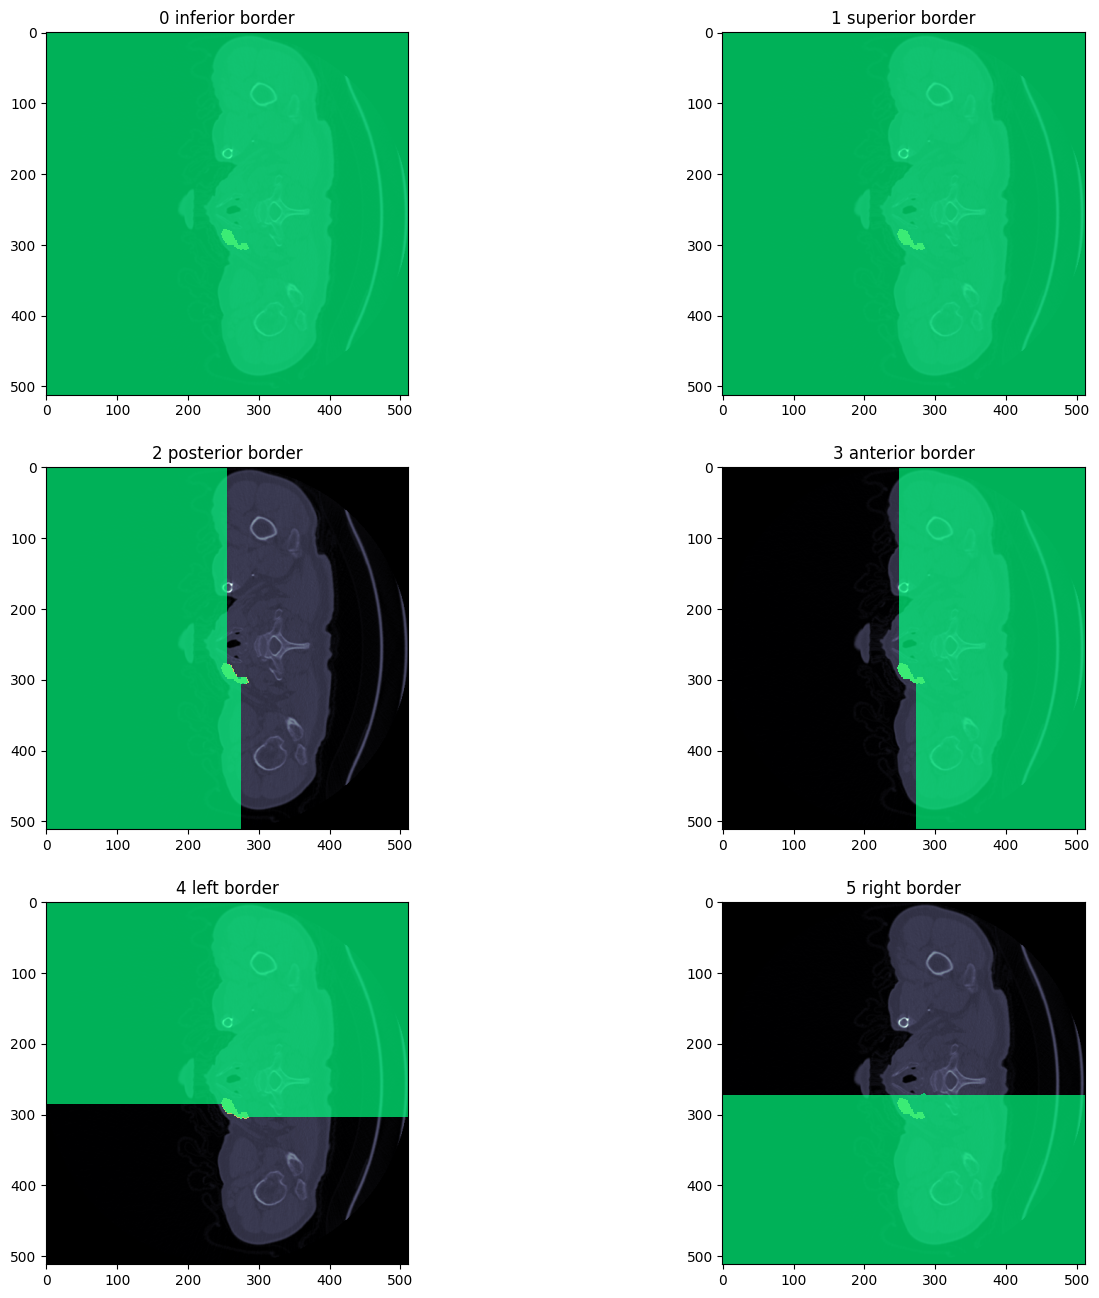

In [163]:
fig, ax = plt.subplots(3,2,figsize=(16,16))

slice_ = 728

for i in range(2):
    for j in range(3):
        ax[j][i].imshow(ct_img[:,:,slice_], cmap='bone')
        ax[j][i].imshow(np.ma.masked_where(organ_segmentation[:,:,slice_] < 0.5,organ_segmentation[:,:,slice_]), cmap='summer', alpha=0.7, vmin=0., vmax=1., interpolation='none')
        ax[j][i].imshow(np.ma.masked_where(mask_list[j*2+i][:,:,slice_] < 0.5, mask_list[j*2+i][:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')
        ax[j][i].set_title(f'{j*2+i} {list(myspecs.keys())[j*2+i]}')
        #ax[j][i].plot([246,246],[0,512],)
        #ax[j][i].plot([0,512],[285,285],)
        #new_mask = torch.zeros_like(mask_list[j*2+i][:,:,slice_])
        #new_mask[:285,:246] = 1
        #ax[j][i].imshow(np.ma.masked_where(new_mask < 0.5, new_mask), cmap='summer', alpha=0.7, vmin=0., vmax=1., interpolation='none')



plt.show()

In [88]:
x = np.array([0,1,2,3,4,5,6,7,8,9])
w = [2,6,7]
np.argmin(x[w])

np.int64(0)

### Small test

In [81]:
organ_segmentation = np.array(
                      [[0,0,1,1,0,0],
                      [0,0,0,1,1,0],
                      [0,0,0,0,1,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]])
organ_segmentation = organ_segmentation[:,:,None]

In [99]:
indices = [[],[],[]]
w = np.array(np.where(organ_segmentation > 0))
other_ax = [0,1,2]
_ = other_ax.pop(axis)
ax1 = other_ax[-1]
ax2 = other_ax[0]
for ax1_idx in np.unique(w[ax1,:]):
    for ax2_idx in np.unique(w[ax2,w[ax1,:] == ax1_idx]):
        axis_idx = np.max(w[axis,(w[ax1,:] == ax1_idx)&(w[ax2,:] == ax2_idx)]) if get_largest_index else np.min(w[axis,(w[ax1,:] == ax1_idx)&(w[ax2,:] == ax2_idx)])
        indices[ax1].append(int(ax1_idx))
        indices[ax2].append(int(ax2_idx))
        indices[axis].append(int(axis_idx))
        print(ax1_idx, ax2_idx, axis_idx)

0 2 0
0 3 1
0 4 2
0 5 3


In [100]:
area_mask = np.zeros_like(organ_segmentation)
for i in range(len(indices[0])):
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = indices[ax1][i]
    selecting_slice[ax2] = indices[ax2][i]
    selecting_slice[axis] = slice(indices[axis][i], None) if one_after else slice(None, indices[axis][i])
    print(selecting_slice)
    area_mask[*selecting_slice] = 1

[slice(None, 0, None), 2, 0]
[slice(None, 1, None), 3, 0]
[slice(None, 2, None), 4, 0]
[slice(None, 3, None), 5, 0]


In [101]:
organ_segmentation[...,0]

array([[0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [102]:
area_mask[...,0]

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])